In [1]:
%load_ext autoreload

In [127]:
%autoreload 2

In [138]:
from prefect import Flow, Parameter
import pandas as pd


In [139]:
input_df = pd.read_csv("../data/house-prices-advanced-regression-techniques/train.csv")
test= pd.read_csv("../data/house-prices-advanced-regression-techniques/test.csv")

In [140]:
from ml_flow import *
with Flow("data_cleaning") as flow:
    input_data = Parameter("input_data")
    problem, target, features = Parameter("problem"), Parameter("target"), Parameter("features")
    train_valid_split = extract_train_valid_split(input_data = input_data, problem = problem, target = target)
    train_data = extract_train_data(train_valid_split)
    valid_data = extract_valid_data(train_valid_split)
    nan_features = extract_nan_features(input_data)
    problematic_features = extract_problematic_features(input_data)
    undefined_features = extract_undefined_features(input_data, features, target,nan_features,problematic_features)
    numeric_features = extract_numeric_features(input_data,undefined_features)
    categorical_features = extract_categorical_features(input_data,undefined_features)
    missing_indicator = fit_missing_indicator(train_data,undefined_features)
    train_transformed_missing = transform_missing_indicator_df(train_data, undefined_features,missing_indicator)
    valid_transformed_missing = transform_missing_indicator_df(valid_data,undefined_features,missing_indicator)
    numeric_imputer = fit_numeric_imputer(train_data,numeric_features)
    imputed_train_numeric_df = transform_numeric_df(numeric_imputer,train_data,numeric_features)
    imputed_valid_numeric_df = transform_numeric_df(numeric_imputer,valid_data,numeric_features)
    yeo_johnson_transformer = fit_yeo_johnson_transformer(imputed_train_numeric_df)
    yeo_johnson_train_transformed = transform_yeo_johnson_transformer(imputed_train_numeric_df,yeo_johnson_transformer)
    yeo_johnson_valid_transformed = transform_yeo_johnson_transformer(imputed_valid_numeric_df,yeo_johnson_transformer)
    transformed_target = transform_target(problem,target,train_data, yeo_johnson_transformer)
    
    
    
    #hbos_transformer = fit_hbos_transformer(train_)




In [141]:
flow.run(
    input_data= input_df, 
    problem="regression", 
    target = "SalePrice", 
    features = "infer"
)

[2020-02-16 01:10:11,140] INFO - prefect.FlowRunner | Beginning Flow run for 'data_cleaning'
[2020-02-16 01:10:11,141] INFO - prefect.FlowRunner | Starting flow run.
[2020-02-16 01:10:11,147] INFO - prefect.TaskRunner | Task 'features': Starting task run...
[2020-02-16 01:10:11,150] INFO - prefect.TaskRunner | Task 'features': finished task run for task with final state: 'Success'
[2020-02-16 01:10:11,155] INFO - prefect.TaskRunner | Task 'target': Starting task run...
[2020-02-16 01:10:11,157] INFO - prefect.TaskRunner | Task 'target': finished task run for task with final state: 'Success'
[2020-02-16 01:10:11,162] INFO - prefect.TaskRunner | Task 'problem': Starting task run...
[2020-02-16 01:10:11,164] INFO - prefect.TaskRunner | Task 'problem': finished task run for task with final state: 'Success'
[2020-02-16 01:10:11,169] INFO - prefect.TaskRunner | Task 'input_data': Starting task run...
[2020-02-16 01:10:11,172] INFO - prefect.TaskRunner | Task 'input_data': finished task run f

<Failed: "Some reference tasks failed.">

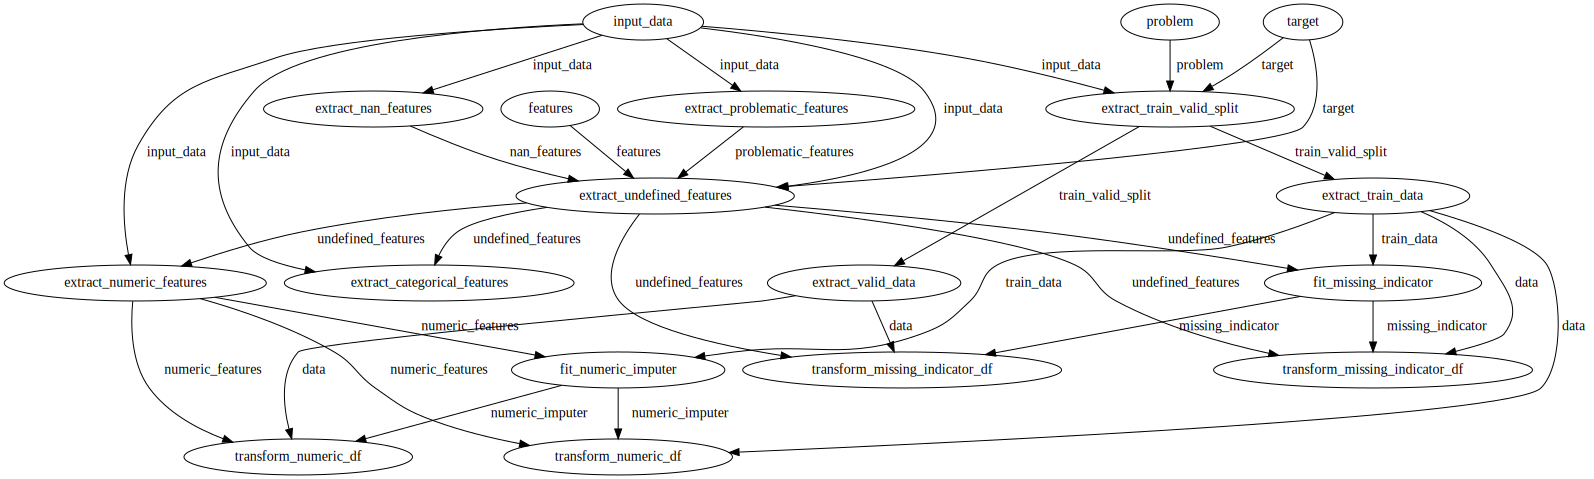

In [112]:
flow.visualize()